In [37]:
import six
import os
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import ticker

from stompy import utils
import matplotlib.pyplot as plt


from stompy.model import data_comparison
from stompy.model.delft import dflow_model

%matplotlib notebook

In [38]:
six.moves.reload_module(dflow_model)

<module 'stompy.model.delft.dflow_model' from '/home/rusty/src/stompy/stompy/model/delft/dflow_model.py'>

In [39]:
#model=dflow_model.DFlowModel.load("runs/val-201404_v00/flowfm.mdu")
model=dflow_model.DFlowModel.load("runs/val-201404_v01/flowfm.mdu")
#model=dflow_model.DFlowModel.load("runs/struct_test_v01/flowfm.mdu")

In [40]:
# CSV datasources:
base_dir="."
csv_dir=os.path.join(base_dir,"calibration_data")

In [41]:
fig_dir=os.path.join(os.path.dirname(model.his_output()),"figs-20190523")
os.path.exists(fig_dir) or os.mkdir(fig_dir)

True

In [42]:
def add_flow(name,csv_fn,**extra):
    fn=os.path.join(csv_dir,csv_fn)
    df=pd.read_csv(fn,parse_dates=['Time'])
    obs=xr.Dataset.from_dataframe(df)
    # standardize and add metadata
    obs['time']=('time',),df.Time.values
    obs.time.attrs['timezone']='PST'
    obs['flow']=('time',),obs.Flow*0.028316847
    obs.flow.attrs['units']='m3 s-1'
    obs_da=obs.flow

    mod=model.extract_section(name=name)

    model_da=mod.cross_section_discharge
    model_da.name='flow'
    model_da=model_da.isel(time=model_da.time-model_da.time.values[0]>np.timedelta64(24,'h'))

    model_da.attrs['label']="Model"
    obs_da.attrs['label']="Obs."

    model_da=model_da.assign_coords(label="Model")
    obs_da=obs_da.assign_coords(label="Obs.")

    plot_def=dict(sources=[obs_da,model_da],
                  station_name=name)
    plot_def.update(extra)
    plot_defs.append(plot_def)


In [43]:
def add_stage(name,csv_fn,**extra):
    fn=os.path.join(csv_dir,csv_fn)
    df=pd.read_csv(fn,parse_dates=['Time'])
    obs=xr.Dataset.from_dataframe(df)
    # standardize and add metadata
    obs['time']=('time',),df.Time.values
    obs.time.attrs['timezone']='PST'
    obs['water_level']=('time',),obs.Stage
    obs.water_level.attrs['units']='m'
    
    # some source files have missing records
    invalid=utils.isnat(obs.time.values)
    obs=obs.isel(time=~invalid)
    
    obs_da=obs.water_level

    mod=model.extract_station(name=name)

    model_da=mod.waterlevel
    model_da.name='water_level'
    model_da=model_da.isel(time=model_da.time-model_da.time.values[0]>np.timedelta64(24,'h'))

    model_da.attrs['label']="Model"
    obs_da.attrs['label']="Obs."

    model_da=model_da.assign_coords(label="Model")
    obs_da=obs_da.assign_coords(label="Obs.")

    plot_def=dict(sources=[obs_da,model_da],
                  station_name=name)
    plot_def.update(extra)
    plot_defs.append(plot_def)
    

In [44]:
plot_defs=[]
add_flow("DOP","DOP_flow_cfs.csv")
add_stage("CCS",'CCS_orig_stage_m.csv')
add_stage("LN2",'HecDssExcel6060592544570966047_LN2_wsel.csv',
          zoom_period=[735336.386, 735347.])


<IPython.core.display.Javascript object>


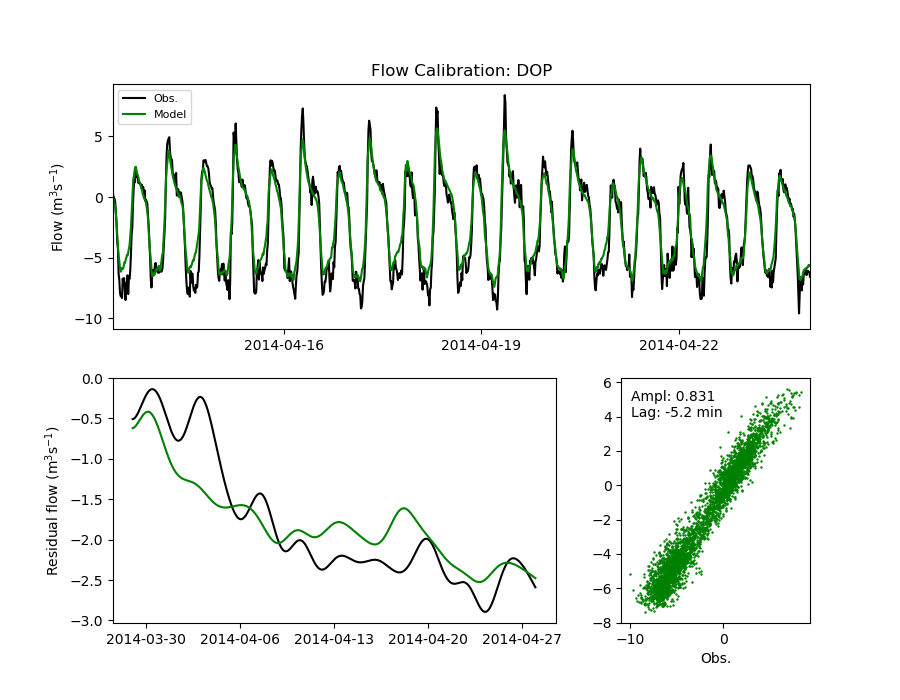

<IPython.core.display.Javascript object>


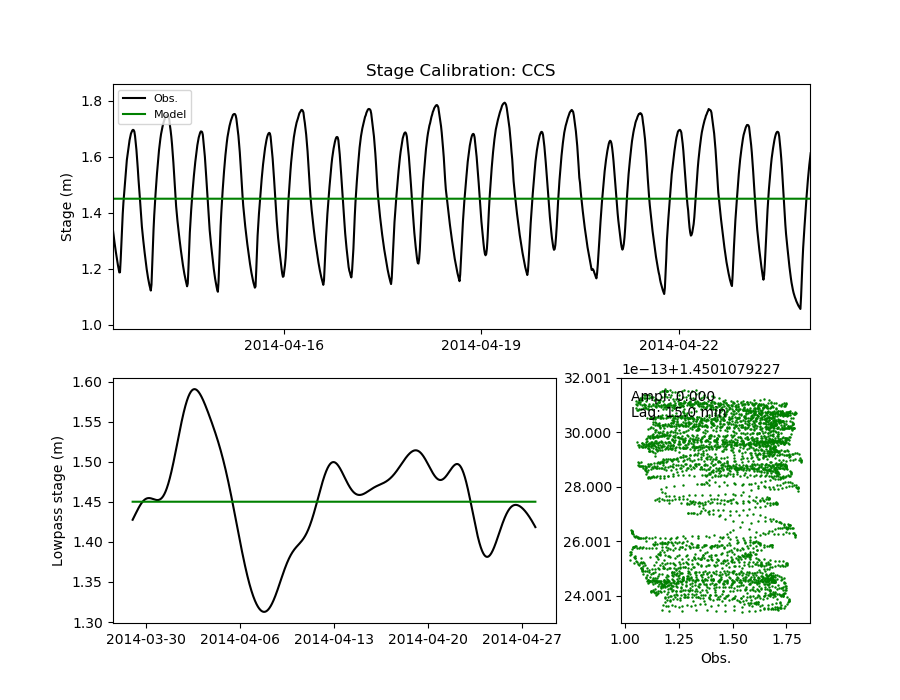

<IPython.core.display.Javascript object>


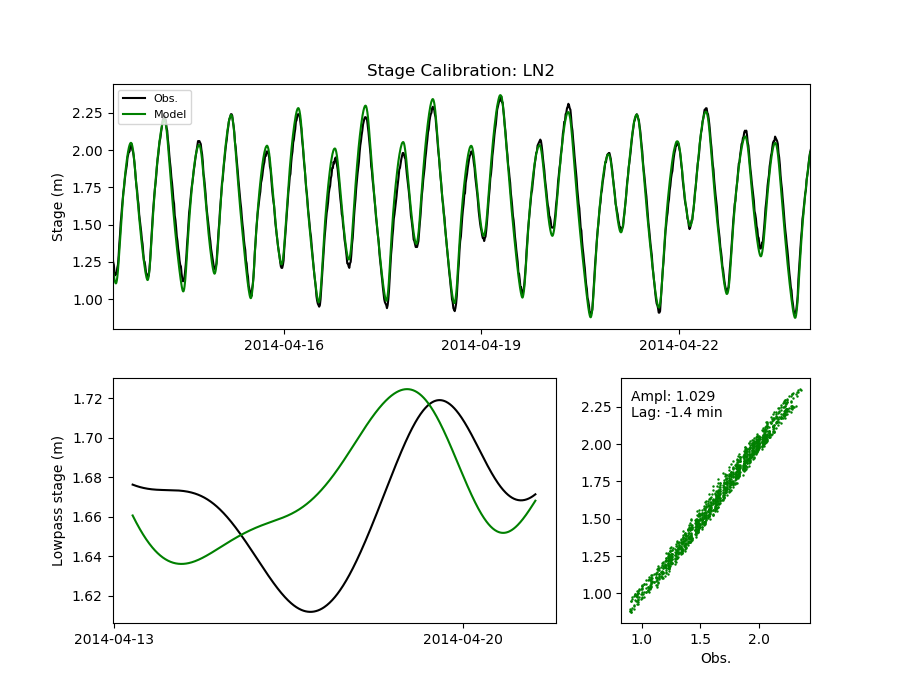

In [45]:
six.moves.reload_module(data_comparison)

defaults=dict( zoom_period=[735336.386, 735347.])
# zoom_period=[735326.6,735342.00] )

for plot_def in plot_defs:
    settings=dict(defaults)# copy
    settings.update(plot_def)
    srcs=settings['sources']
    fig=data_comparison.calibration_figure_3panel(srcs,trim_time=True,
                                                  styles=[dict(color='k'),
                                                          dict(color='g')])
    param=srcs[0].name
    
    if param=='flow':
        fig.axes[0].set_ylabel('Flow (m$^3$s$^{-1}$)')
        fig.axes[1].set_ylabel('Residual flow (m$^3$s$^{-1}$)')
        fig.axes[0].set_title("Flow Calibration: %s"%plot_def['station_name'])
    elif param=='water_level':
        fig.axes[0].set_ylabel('Stage (m)')
        fig.axes[1].set_ylabel('Lowpass stage (m)')
        fig.axes[0].set_title("Stage Calibration: %s"%plot_def['station_name'])
        
    fig.axes[0].axis(xmin=settings['zoom_period'][0],
                     xmax=settings['zoom_period'][1])

    # this really should be automatic, but RRuleLocator does some weird stuff
    # with months.
    fig.axes[0].xaxis.set_major_locator(ticker.MultipleLocator(3))
    fig.axes[1].xaxis.set_major_locator(ticker.MultipleLocator(7))
    fig.subplots_adjust(wspace=0.35)

    img_fn=os.path.join(fig_dir,"%s-%s.png"%(plot_def['station_name'],
                                             param))
    fig.savefig(img_fn,dpi=200)